In [1]:
import pandas as pd
import numpy as np
from patsy import dmatrices, dmatrix
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Questions

1. I chose a random forest model with parameters such as:
            criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300
    
    I chose this model because it gave the fewest number of misclassifications. Although logistic gave the highest AUC, it seemed to predict the minority class too often.

2. I tried other models such as neural network and logistic regression. I think random forest does well in this case because it tends to be an accurate classifier, and ensembling/averaging makes overfitting less likeley.

3. I handled missing data for age and schooling, and for categorical variables with missing values I coded them as 'unknown'. For age, I imputed with the mean age for each profession, and schooling I imputed with the mode schooling for each profession. Because profession could be a decent indicator for age and schooling.

4. I handled categorical data by converting them to dummy variables.

5. I handled unbalanced data by using weights associated with the classes, instead of giving all classes weight one. The “balanced” mode I am using uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data. For the neural network model, I tried SMOTE.

6. I tested my model by splitting a train and test set (70-30% ratio). I got some optimal parameters through cross-validation, and then tested the fitted model on the test set.

In [2]:
df = pd.read_csv('marketing_training.csv')
df = df.rename(columns={'emp.var.rate': 'erate', 'cons.price.idx': 'cpi', 'cons.conf.idx':'cci', 'nr.employed':'nremploy'})
df.head()

,custAge,profession,marital,schooling,default,housing,loan,contact,month,day_of_week,...,previous,poutcome,erate,cpi,cci,euribor3m,nremploy,pmonths,pastEmail,responded
0,55.0,admin.,single,university.degree,unknown,no,no,cellular,nov,mon,...,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,999.0,0,no
1,NaN,blue-collar,married,NaN,no,no,no,cellular,jul,mon,...,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,999.0,0,no
2,42.0,technician,married,high.school,no,no,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,999.0,0,no
3,55.0,management,divorced,NaN,unknown,yes,yes,cellular,jul,wed,...,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,999.0,0,no
4,NaN,admin.,divorced,university.degree,no,yes,no,cellular,may,tue,...,1,failure,-1.8,92.893,-46.2,1.291,5099.1,999.0,1,no


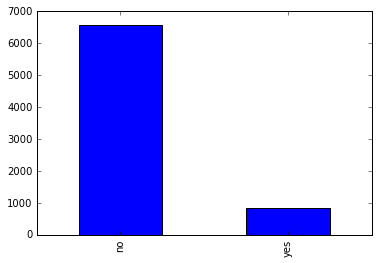

In [3]:
# imbalanced data
df['responded'].value_counts().plot(kind='bar')

In [4]:
# missing values exploration - fill age with mean by profession
df.groupby("profession")['custAge'].mean().sort_values(ascending=False)

profession
retired          62.741525
unknown          47.955556
housemaid        47.207143
management       42.044444
entrepreneur     41.341014
self-employed    40.102041
blue-collar      39.260125
unemployed       38.878788
services         38.577206
technician       38.093509
admin.           38.067626
student          26.366071
Name: custAge, dtype: float64

In [5]:
# missing values exploration - fill schooling with most commonly occuring by profession
school = df.groupby("profession")['schooling'].agg(lambda x:x.value_counts().index[0])
school

profession
admin.             university.degree
blue-collar                 basic.9y
entrepreneur       university.degree
housemaid                   basic.4y
management         university.degree
retired                     basic.4y
self-employed      university.degree
services                 high.school
student                  high.school
technician       professional.course
unemployed               high.school
unknown                      unknown
Name: schooling, dtype: object

In [6]:
# missing values

def missingvalues(df_name):
    df_name["custAge"] = df_name.groupby("profession").transform(lambda x: x.fillna(x.mean()))
    df_name["custAge"] = df_name['custAge'].apply(lambda x: round(x,0))
    
    school = df_name.groupby("profession")['schooling'].agg(lambda x:x.value_counts().index[0])
    def fillschool(x):    
        if pd.isnull(x['schooling']):
            return school[x['profession']]
        else:
            return x['schooling']
    df_name['schooling'] = df_name.apply(fillschool, axis=1)

    # create category for unknown values
    df_name['day_of_week'] = df_name['day_of_week'].fillna('unknown')
    return df_name
df = missingvalues(df)

In [7]:
# exploring variables
df.groupby(["nremploy", "responded"]).size()

nremploy  responded
4963.6    no             77
          yes            61
4991.6    no             80
          yes            72
5008.7    no             45
          yes            68
5017.5    no            102
          yes            84
5023.5    no             11
          yes            15
5076.2    no            198
          yes            95
5099.1    no           1371
          yes           228
5176.3    no              1
5191.0    no           1353
          yes            44
5195.8    no            638
          yes            36
5228.1    no           2698
          yes           137
dtype: int64

In [8]:
# binning values

def binningvalues(df_name):
    def bindata(colname, bins, group_names):
        categories = pd.cut(df_name[colname], bins, labels=group_names)
        df_name[colname+'_bin'] = pd.cut(df_name[colname], bins, labels=group_names)

    bindata('custAge', [0, 30, 40, 50, 60, 1000], ['20s','30s','40s','50s','60+'])
    bindata('campaign', [0, 3, 8, 100], ['low','med','high'])
    bindata('pdays', [-1, 7, 900, 1000], ['one wk','more than 1 wk','not contacted'])

    df_name.loc[df_name['schooling']=='basic.4y', 'schooling'] = 'up to hs'
    df_name.loc[df_name['schooling']=='basic.6y', 'schooling'] = 'up to hs'
    df_name.loc[df_name['schooling']=='basic.9y', 'schooling'] = 'up to hs'
    df_name.loc[df_name['schooling']=='high.school', 'schooling'] = 'up to hs'

    df_name.loc[df_name['poutcome']=='nonexistent', 'poutcome'] = 'failure'
    return df_name
df = binningvalues(df)

In [9]:
# modeling

formula = 'responded ~ C(custAge_bin) + C(profession) + C(marital) + C(schooling) + C(default) + C(housing) + C(loan) +\
C(contact) + C(month) + C(campaign_bin) + C(pdays_bin) + C(poutcome) + erate + cpi + cci + euribor3m + nremploy'

y, X = dmatrices(formula, df, return_type='dataframe')
y = y['responded[yes]'].values

In [10]:
pd.DataFrame(y)[0].value_counts()

0.0    6574
1.0     840
Name: 0, dtype: int64

In [11]:
# test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [12]:
# random forest
rf = RandomForestClassifier(class_weight='balanced')
rf_opt = GridSearchCV(rf, param_grid=[{"n_estimators": [100,200,300], "max_features": [None, 'sqrt', 'log2']}])
rf_opt.fit(X_train, y_train)

rf = rf_opt.best_estimator_
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features=None,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [13]:
prediction_train = rf.predict(X_train)
prediction_test = rf.predict(X_test)

print roc_auc_score(y_train, prediction_train) 
print confusion_matrix(y_train, prediction_train)

print roc_auc_score(y_test, prediction_test)
print confusion_matrix(y_test, prediction_test)

0.985549840311
[[4523   71]
 [   8  587]]
0.622170686456
[[1890   90]
 [ 174   71]]


In [14]:
# smote oversampling
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(X_train, y_train)
print df['responded'].value_counts()
print pd.DataFrame(y_res)[0].value_counts()

no     6574
yes     840
Name: responded, dtype: int64
1.0    4594
0.0    4594
Name: 0, dtype: int64


In [15]:
# neural network

# standardize data
scaler = StandardScaler()
scaler.fit(X_res)
X_train_s = scaler.transform(X_res)
X_test_s = scaler.transform(X_test)

mlp = MLPClassifier()
mlp_opt = GridSearchCV(mlp, param_grid={'learning_rate_init': [0.01, 0.005, 0.001], 'activation': ["relu", "logistic", "tanh"]})
mlp_opt.fit(X_train_s, y_res)

mlp = mlp_opt.best_estimator_
mlp.fit(X_train_s, y_res)

C:\Users\ohong\Anaconda2\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [16]:
prediction_train = mlp.predict(X_train_s)
prediction_test = mlp.predict(X_test_s)

print roc_auc_score(y_res, prediction_train) 
print confusion_matrix(y_res, prediction_train)

print roc_auc_score(y_test, prediction_test)
print confusion_matrix(y_test, prediction_test)

0.962124510231
[[4372  222]
 [ 126 4468]]
0.650273139559
[[1775  205]
 [ 146   99]]


In [17]:
# logistic

log = LogisticRegression(class_weight='balanced')
log_opt = GridSearchCV(log, param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] })
log_opt.fit(X_train, y_train)

log = log_opt.best_estimator_
log.fit(X_train, y_train)

LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [18]:
prediction_train = log.predict(X_train)
prediction_test = log.predict(X_test)

print roc_auc_score(y_train, prediction_train) 
print confusion_matrix(y_train, prediction_train)

print roc_auc_score(y_test, prediction_test)
print confusion_matrix(y_test, prediction_test)

0.752812949298
[[3813  781]
 [ 193  402]]
0.737327355184
[[1651  329]
 [  88  157]]


# Getting predictions

In [19]:
df2 = pd.read_csv('marketing_test.csv')
df_test = df2.rename(columns={'emp.var.rate': 'erate', 'cons.price.idx': 'cpi', 'cons.conf.idx':'cci', 'nr.employed':'nremploy'})
df_test = df_test.drop(['Unnamed: 0'], axis=1)
df_test.head()

,custAge,profession,marital,schooling,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,erate,cpi,cci,euribor3m,nremploy,pmonths,pastEmail
0,NaN,entrepreneur,married,university.degree,no,yes,no,cellular,jul,wed,...,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,999.0,0
1,58.0,entrepreneur,married,university.degree,unknown,no,no,telephone,jun,fri,...,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,999.0,0
2,48.0,entrepreneur,married,NaN,no,no,no,cellular,jul,mon,...,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,999.0,0
3,35.0,blue-collar,married,NaN,no,yes,no,telephone,jun,tue,...,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1,999.0,0
4,39.0,blue-collar,married,basic.6y,no,no,no,cellular,jul,mon,...,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,999.0,0


In [20]:
# repeat preprocessing

df_test = missingvalues(df_test)
df_test = binningvalues(df_test)

In [21]:
formula = 'C(custAge_bin) + C(profession) + C(marital) + C(schooling) + C(default) + C(housing) + C(loan) +\
C(contact) + C(month) + C(campaign_bin) + C(pdays_bin) + C(poutcome) + erate + cpi + cci + euribor3m + nremploy'

X_final = dmatrix(formula, df_test, return_type='dataframe')

In [22]:
# find which dummy columns are missing in test
print set(X.columns.values)^set(X_final.columns.values)

# create those columns with 0s
X_final['C(default)[T.yes]'] = 0 
X_final['C(schooling)[T.professional.course]'] = 0 

set(['C(schooling)[T.professional.course]', 'C(default)[T.yes]'])


In [23]:
# fit data on entire training
rf.fit(X, y)
final_pred = rf.predict(X_final)

# attach predictions to original data
df2['responded'] = pd.Series(final_pred, index=df2.index)
df2.head()

,Unnamed: 0,custAge,profession,marital,schooling,default,housing,loan,contact,month,...,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail,responded
0,0,NaN,entrepreneur,married,university.degree,no,yes,no,cellular,jul,...,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,999.0,0,0.0
1,1,58.0,entrepreneur,married,university.degree,unknown,no,no,telephone,jun,...,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,999.0,0,0.0
2,2,48.0,entrepreneur,married,NaN,no,no,no,cellular,jul,...,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,999.0,0,0.0
3,3,35.0,blue-collar,married,NaN,no,yes,no,telephone,jun,...,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1,999.0,0,0.0
4,4,39.0,blue-collar,married,basic.6y,no,no,no,cellular,jul,...,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,999.0,0,0.0


In [24]:
df2.to_csv('predictions.csv')

In [25]:
df2['responded'].value_counts()

0.0    777
1.0     47
Name: responded, dtype: int64